In [1]:
import numpy as np
np.random.seed(1337)
import pandas as pd

In [2]:
# loading dataset 
train = pd.read_csv("./widsdatathon2020_data/training_v2.csv")
test = pd.read_csv("./widsdatathon2020_data/unlabeled.csv")

In [3]:
train.dropna(inplace=True)

In [4]:
train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
8286,80443,9930,89,1,67.0,28.146291,0,Caucasian,M,167.64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
8492,66332,22503,89,0,60.0,34.574559,0,Caucasian,M,177.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
8717,107612,82369,89,0,66.0,25.775925,1,Caucasian,M,185.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Musculoskeletal/Skin,Undefined diagnoses
8727,88203,95246,89,0,55.0,56.659238,0,Other/Unknown,F,162.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
9235,77729,21614,89,0,21.0,22.180764,0,Caucasian,M,182.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


In [5]:
train.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [6]:
test.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [7]:
train = train.select_dtypes(exclude=['object'])

In [8]:
dictionary = pd.read_csv('./widsdatathon2020_data/WiDS Datathon 2020 Dictionary.csv')

In [9]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


In [10]:
y = train['hospital_death']
X = train
X = train.drop('hospital_death',axis = 1)
test = test.drop('hospital_death',axis = 1)

In [11]:
# unique labels in the output
y.unique()

array([1, 0])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#train a model
model = Sequential()
n_cols = x_train.shape[1]
model.add(Dense(10000,activation='relu', input_shape=(n_cols,)))
model.add(Dense(1))



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
sgd = optimizers.SGD(lr=0.5)
optimizer = model.compile(sgd, loss='binary_crossentropy',metrics=['accuracy'])
epochs=100

predictions = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=100)

Train on 20 samples, validate on 5 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
20/20 [==============================] - 1s 40ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 2/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 3/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 4/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 5/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 6/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 7/100
20/20 [==============================] - 0s 1ms/samp

Epoch 60/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 61/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 62/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 63/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 64/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 65/100
20/20 [==============================] - 0s 1ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 66/100
20/20 [==============================] - 0s 952us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 67/100
20/20 [==============================] - 0s 1ms

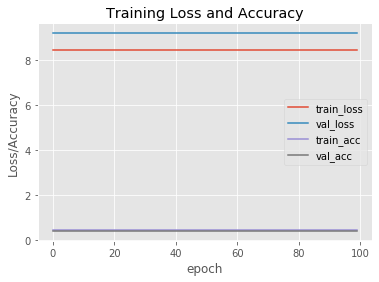

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# plot the training loss and accuracy
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, predictions.history["loss"], label="train_loss")
plt.plot(N, predictions.history["val_loss"], label="val_loss")
plt.plot(N, predictions.history["acc"], label="train_acc")
plt.plot(N, predictions.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [16]:
# standardize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scale = scaler.fit_transform(x_train.values)
x_scale_test = scaler.fit_transform(x_test.values)

In [17]:
#train a model
model = Sequential()
n_cols = x_train.shape[1]
model.add(Dense(10,activation='relu', input_shape=(n_cols,)))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.01)
optimizer = model.compile(sgd, loss='binary_crossentropy',metrics=['accuracy'])
epochs=1000

predictions = model.fit(x_scale,y_train, validation_data=(x_scale_test,y_test), epochs=100, batch_size=100)

Train on 20 samples, validate on 5 samples
Epoch 1/100
20/20 [==============================] - 1s 65ms/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 2/100
20/20 [==============================] - 0s 354us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 3/100
20/20 [==============================] - 0s 407us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 4/100
20/20 [==============================] - 0s 384us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 5/100
20/20 [==============================] - 0s 443us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 6/100
20/20 [==============================] - 0s 448us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 7/100
20/20 [==============================] - 0s 604us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 8/100
2

Epoch 61/100
20/20 [==============================] - 0s 536us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 62/100
20/20 [==============================] - 0s 430us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 63/100
20/20 [==============================] - 0s 456us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 64/100
20/20 [==============================] - 0s 408us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 65/100
20/20 [==============================] - 0s 365us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 66/100
20/20 [==============================] - 0s 381us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 67/100
20/20 [==============================] - 0s 347us/sample - loss: 6.9412 - acc: 0.5500 - val_loss: 6.1700 - val_acc: 0.6000
Epoch 68/100
20/20 [============================

In [26]:
#train a model
model = Sequential()
n_cols = x_train.shape[1]
model.add(Dense(10,activation='relu', input_shape=(n_cols,)))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.1)
optimizer = model.compile(sgd, loss='binary_crossentropy',metrics=['accuracy'])
epochs=1000

predictions = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=100)

Train on 20 samples, validate on 5 samples
Epoch 1/100
20/20 [==============================] - 1s 32ms/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 2/100
20/20 [==============================] - 0s 328us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 3/100
20/20 [==============================] - 0s 345us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 4/100
20/20 [==============================] - 0s 379us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 5/100
20/20 [==============================] - 0s 396us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 6/100
20/20 [==============================] - 0s 412us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 7/100
20/20 [==============================] - 0s 445us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 8/100
2

Epoch 61/100
20/20 [==============================] - 0s 353us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 62/100
20/20 [==============================] - 0s 440us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 63/100
20/20 [==============================] - 0s 426us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 64/100
20/20 [==============================] - 0s 350us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 65/100
20/20 [==============================] - 0s 379us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 66/100
20/20 [==============================] - 0s 456us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 67/100
20/20 [==============================] - 0s 430us/sample - loss: 8.4333 - acc: 0.4500 - val_loss: 9.1999 - val_acc: 0.4000
Epoch 68/100
20/20 [============================

In [41]:
model = Sequential()
model.add(Dense(128, input_shape=(177,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
optim = optimizers.SGD(lr=0.01)
model.compile(optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
predictions = model.fit(x_scale,y_train, validation_data=(x_scale_test,y_test), epochs=100)

Train on 20 samples, validate on 5 samples
Epoch 1/100
20/20 [==============================] - 1s 29ms/sample - loss: 0.9322 - acc: 0.4500 - val_loss: 1.0666 - val_acc: 0.4000
Epoch 2/100
20/20 [==============================] - 0s 322us/sample - loss: 0.8521 - acc: 0.4500 - val_loss: 0.9746 - val_acc: 0.4000
Epoch 3/100
20/20 [==============================] - 0s 365us/sample - loss: 0.7977 - acc: 0.4500 - val_loss: 0.9101 - val_acc: 0.4000
Epoch 4/100
20/20 [==============================] - 0s 438us/sample - loss: 0.7596 - acc: 0.4000 - val_loss: 0.8633 - val_acc: 0.4000
Epoch 5/100
20/20 [==============================] - 0s 507us/sample - loss: 0.7326 - acc: 0.4000 - val_loss: 0.8258 - val_acc: 0.4000
Epoch 6/100
20/20 [==============================] - 0s 460us/sample - loss: 0.7123 - acc: 0.3500 - val_loss: 0.7975 - val_acc: 0.4000
Epoch 7/100
20/20 [==============================] - 0s 490us/sample - loss: 0.6965 - acc: 0.4500 - val_loss: 0.7757 - val_acc: 0.4000
Epoch 8/100
2

Epoch 61/100
20/20 [==============================] - 0s 635us/sample - loss: 0.4737 - acc: 0.9000 - val_loss: 0.6535 - val_acc: 0.6000
Epoch 62/100
20/20 [==============================] - 0s 585us/sample - loss: 0.4706 - acc: 0.9500 - val_loss: 0.6533 - val_acc: 0.6000
Epoch 63/100
20/20 [==============================] - 0s 971us/sample - loss: 0.4676 - acc: 0.9500 - val_loss: 0.6524 - val_acc: 0.6000
Epoch 64/100
20/20 [==============================] - 0s 983us/sample - loss: 0.4646 - acc: 0.9500 - val_loss: 0.6521 - val_acc: 0.6000
Epoch 65/100
20/20 [==============================] - 0s 647us/sample - loss: 0.4617 - acc: 0.9500 - val_loss: 0.6509 - val_acc: 0.6000
Epoch 66/100
20/20 [==============================] - 0s 465us/sample - loss: 0.4588 - acc: 0.9500 - val_loss: 0.6511 - val_acc: 0.6000
Epoch 67/100
20/20 [==============================] - 0s 569us/sample - loss: 0.4559 - acc: 0.9500 - val_loss: 0.6501 - val_acc: 0.6000
Epoch 68/100
20/20 [============================

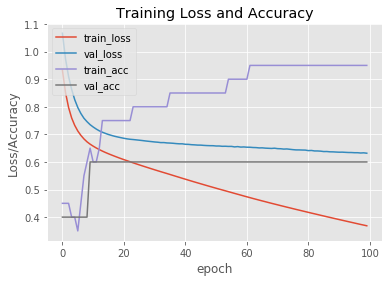

In [43]:
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, predictions.history["loss"], label="train_loss")
plt.plot(N, predictions.history["val_loss"], label="val_loss")
plt.plot(N, predictions.history["acc"], label="train_acc")
plt.plot(N, predictions.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [36]:
model.fit?